In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dropout
from keras.layers import BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1a. Resize dan Data splitting

In [ ]:
data_dir = '/content/drive/MyDrive/Dataset DL UTS/Dataset2B'

class_names = sorted(os.listdir(data_dir))
class_map = {class_name: i for i, class_name in enumerate(class_names)}
num_classes = len(class_names)
img_size = (224, 224, 3)

class_names

['banana', 'betel_nut', 'bitter_gourd', 'black_berry']

In [ ]:
#Load Data
labels = []
images = []

print('images:\n')
for image_classes in class_names:
  print(image_classes, end=': ')
  for img in os.listdir(data_dir + '/' + image_classes):
    label = np.zeros(num_classes)
    label[class_names.index(image_classes)] = 1
    labels.append(label)

    image = np.asarray(cv2.resize(cv2.imread(data_dir + '/' + image_classes + '/' + img, cv2.IMREAD_COLOR), img_size[0:2]))
    images.append(image)
  print('loaded')

images:

banana: loaded
betel_nut: loaded
bitter_gourd: loaded
black_berry: loaded


In [ ]:
def load_images():
    global labels, images
    x = np.array(images)
    y = np.array(labels)
    return x, y

# Example usage:
x, y = load_images()
print("Loaded images:", x.shape)
print("Labels:", y.shape)

Loaded images: (1600, 224, 224, 3)
Labels: (1600, 4)


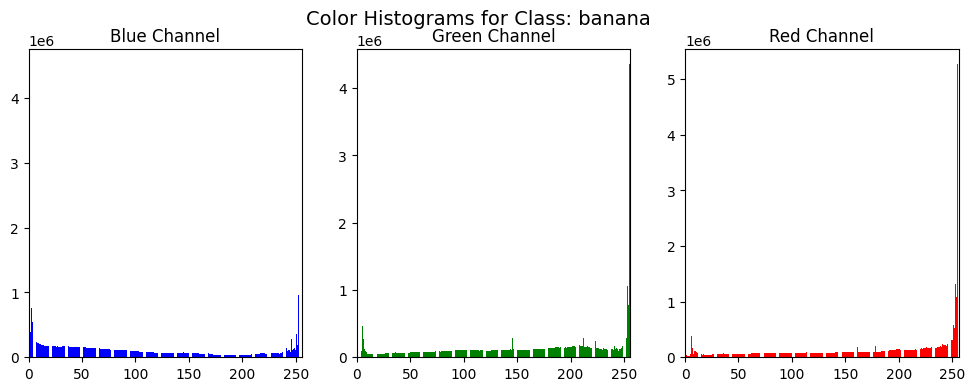

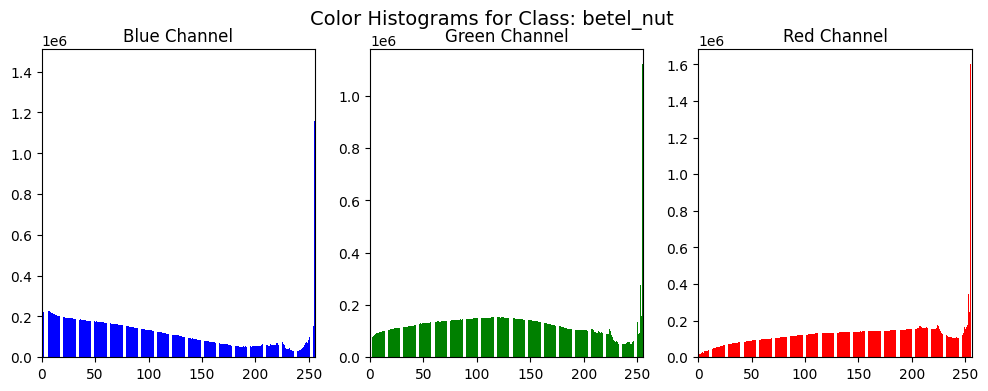

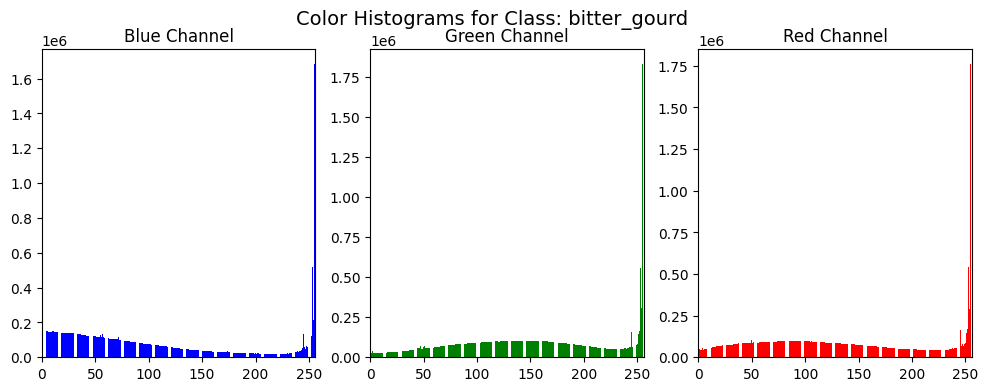

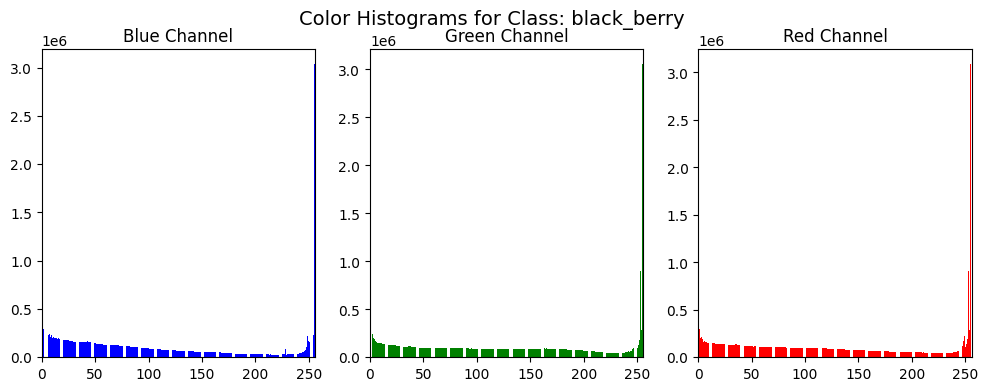

In [ ]:
#Color Histogram per class
hist_per_class = {}

for class_name in os.listdir(data_dir):
    hist_blue = np.zeros(256)
    hist_green = np.zeros(256)
    hist_red = np.zeros(256)
    class_dir = os.path.join(data_dir, class_name)

    for file in os.listdir(class_dir):
        image = cv2.imread(os.path.join(class_dir, file), cv2.IMREAD_COLOR)
        if image is not None:
            b, g, r = cv2.split(image)
            hist_blue += cv2.calcHist([b], [0], None, [256], [0, 256]).flatten()
            hist_green += cv2.calcHist([g], [0], None, [256], [0, 256]).flatten()
            hist_red += cv2.calcHist([r], [0], None, [256], [0, 256]).flatten()

    hist_per_class[class_name] = (hist_blue, hist_green, hist_red)

for class_name, histograms in hist_per_class.items():
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Color Histograms for Class: {class_name}', fontsize=14)

    plt.subplot(1, 3, 1)
    plt.bar(range(256), histograms[0], color='blue')
    plt.xlim([0, 256])
    plt.title('Blue Channel')

    plt.subplot(1, 3, 2)
    plt.bar(range(256), histograms[1], color='green')
    plt.xlim([0, 256])
    plt.title('Green Channel')

    plt.subplot(1, 3, 3)
    plt.bar(range(256), histograms[2], color='red')
    plt.xlim([0, 256])
    plt.title('Red Channel')

    plt.show()


* Banana: didominasi oleh warna merah dengan variasi intensitas biru dan hijau yang lebih rendah
* Betel_nut: didominasi oleh warna hijau menengah dan merah rendah hingga menengah dengan sedikit variasi intensitas biru
* Bitter_gourd: didominasi oleh semua warna (merah, hijau, dan biru) intensitas rendah hingga menengah
* Black_berry: didominasi oleh warna hijau dan merah intensitas rendah dengan sedikit variasi intensitas biru





In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test_val ,y_test_val, test_size = 0.5, random_state=42)

print("Train data:", x_train.shape[0], x_train.shape[1])
print("Validate data:", x_val.shape[0], x_val.shape[1])
print("Test data:", x_test.shape[0], x_test.shape[1])

Train data: 1280 224
Validate data: 160 224
Test data: 160 224


Split data dengan proporsi 80,10,10

#1b. Identifikasi kesulitan (Image Quality dan Variability)

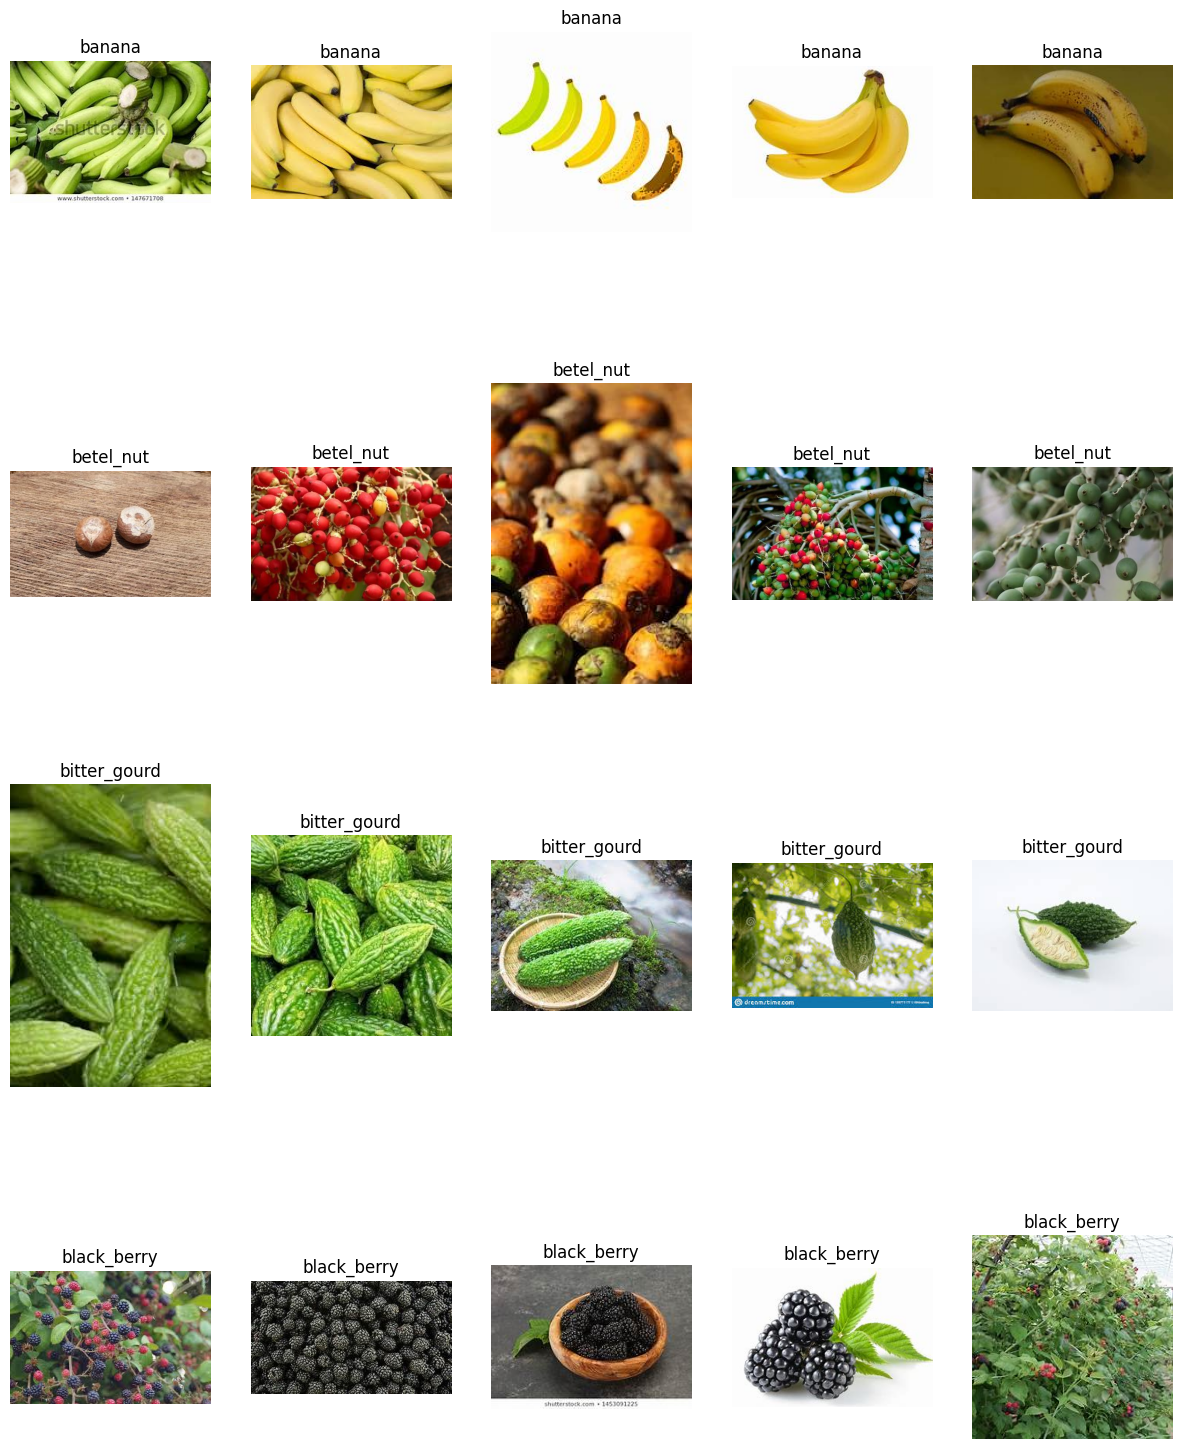

In [ ]:
#Mengambil 5 gambar per class
num_examples_per_class = 5
example_images = []
class_names = os.listdir(data_dir)
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_dir)[:num_examples_per_class]
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        image = cv2.imread(image_path)
        example_images.append((class_name, image))

num_classes = len(class_names)
plt.figure(figsize=(15, 5 * num_classes))
for i, (class_name, image) in enumerate(example_images):
    plt.subplot(num_classes, num_examples_per_class, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(class_name)
    plt.axis('off')
plt.show()

Disini saya mengambil 5 image random dari setiap classnya untuk mengidentifikasi kesulitan
* Image Quality (Resolusi dan Noise): gambar bitter_gourd yang berada diposisi kedua dari kanan, dapat menjadi contoh dari gambar yang merefleksikan kesulitan dalam resolusi, resolusi gambar yang rendah seperti buram dan tidak fokus pada objek
* Kondisi pencahayaan: gambar pisang paling kanan dapat merefleksikan kesulitan dalam pencahayaan, walau tidak terlalu gelap namun pencahayaan dalam foto tersebut kurang.
* Perspektif dan sudut: gambar betel_nut yang berada di tengah dapat merefleksikan kesulitan dalam perspektif dan sudut, dengan mengambil dari sudut tersebut buah betel_nut tidak terlihat secara keseluruhan dan sebagian gambarnya buram
*   Background Variability: gambar black_berry paling kanan dapat merefleksikan kesulitan dalam background variability, foto tersebut tidak menjelaskan tentang buah blackberry karena tidak terlihat dengan jelas dan daun tumbuhan sangat mendistract





#1c. Baseline Architecture

Baseline Architecture

In [ ]:
#VGG-16

model = Sequential()

#Convolution-1
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#Convolution-2
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#Convolution-3
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#Convolution-4
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#Convolution-5
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(4, activation='softmax'))

#Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Disini saya  sudah membangun arsitektur dari VGG-16 yang terdiri dari 5 convolution block dengan jumlah filter dan ukuran kernel yang berbeda-beda. Menggunakan same padding agar ukuran output dari lapisan convolution sama dengan ukuran inputnya. Tipe aktivasi yang digunakan adalah ReLU untuk menambahkan non-linearitas ke dalam model. Setelah setiap convolution block, Max Pooling dilakukan untuk mengurangi dimensi dari fiturnya.

Setelah convolution blocks diflatten, dua lapisan Dense ditambahkan. Lapisan output memiliki 4 neuron sesuai dengan jumlah kelas yang akan diprediksi.

Baseline Model

In [ ]:
#TensorBoard
EPOCHS = 30
BATCH_SIZE = 32

tensorboard = TensorBoard(log_dir=f"logs/{EPOCHS}epochs_{BATCH_SIZE}batch_{img_size}img")

#Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train model with TensorBoard
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=[tensorboard])

Epoch 1/30
40/40 [==============================] - 43s 421ms/step - loss: 224.6946 - accuracy: 0.2781 - val_loss: 1.3901 - val_accuracy: 0.2875
Epoch 2/30
40/40 [==============================] - 16s 411ms/step - loss: 1.3925 - accuracy: 0.2367 - val_loss: 1.3865 - val_accuracy: 0.2750
Epoch 3/30
40/40 [==============================] - 17s 418ms/step - loss: 1.4186 - accuracy: 0.2461 - val_loss: 1.3866 - val_accuracy: 0.2688
Epoch 4/30
40/40 [==============================] - 17s 422ms/step - loss: 1.3891 - accuracy: 0.2391 - val_loss: 1.3877 - val_accuracy: 0.2688
Epoch 5/30
40/40 [==============================] - 17s 426ms/step - loss: 1.3865 - accuracy: 0.2555 - val_loss: 1.3892 - val_accuracy: 0.1937
Epoch 6/30
40/40 [==============================] - 17s 431ms/step - loss: 1.3864 - accuracy: 0.2578 - val_loss: 1.3879 - val_accuracy: 0.1937
Epoch 7/30
40/40 [==============================] - 18s 453ms/step - loss: 1.3863 - accuracy: 0.2578 - val_loss: 1.3887 - val_accuracy: 0.19

TensorBoard digunakan untuk memonitor dan menganalisis kinerja model selama pelatihan.

Model Evaluation

In [ ]:
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis = 1)

#Classification Report
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred) * 100
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro') * 100
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro') * 100
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro') * 100

print('Classification Report for Baseline Model:')
print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))


5/5 [==============================] - 1s 124ms/step
Classification Report for Baseline Model:
Accuracy: 24.38
Precision: 6.09
Recall: 25.00
F1 Score: 9.80


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#1d. Modification Architecture

Modification Architecture

In [ ]:
model2 = Sequential()

#Convolution-1
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))

#Convolution-2
model2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))

#Convolution-3
model2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))

#Convolution-4
model2.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))

#Convolution-5
model2.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))


model2.add(Flatten())
model2.add(Dense(4096, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(4096, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(4, activation='softmax'))

#Compile model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Disini saya hanya menambahkan layer BatchNormalization untuk mempercepat konvergensi dan mencegah overfitting terjadi.
Dalam layer Dense, saya juga menambahkan layer Dropout untuk mengurangi overfitting dengan menghilangkan beberapa neuron secara acak selama training.
Penggunaan BatchNormalization dan Dropout membantu model untuk belajar lebih cepat, stabil dan lebih tahan terhadap overfitting.

Modification Model

In [ ]:
#TensorBoard
EPOCHS = 30
BATCH_SIZE = 32

tensorboard = TensorBoard(log_dir=f"logs/{EPOCHS}epochs_{BATCH_SIZE}batch_{img_size}img")

#Compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train model with TensorBoard
history = model2.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=[tensorboard])

Epoch 1/30
40/40 [==============================] - 34s 594ms/step - loss: 2.9917 - accuracy: 0.5023 - val_loss: 18141.2227 - val_accuracy: 0.1937
Epoch 2/30
40/40 [==============================] - 23s 574ms/step - loss: 0.9520 - accuracy: 0.6734 - val_loss: 44.3154 - val_accuracy: 0.2250
Epoch 3/30
40/40 [==============================] - 22s 562ms/step - loss: 0.7015 - accuracy: 0.7539 - val_loss: 3.9389 - val_accuracy: 0.6438
Epoch 4/30
40/40 [==============================] - 23s 571ms/step - loss: 0.6703 - accuracy: 0.7609 - val_loss: 1.9714 - val_accuracy: 0.6875
Epoch 5/30
40/40 [==============================] - 23s 570ms/step - loss: 0.6691 - accuracy: 0.7742 - val_loss: 1.7762 - val_accuracy: 0.7375
Epoch 6/30
40/40 [==============================] - 23s 564ms/step - loss: 0.5842 - accuracy: 0.7930 - val_loss: 1.2253 - val_accuracy: 0.7000
Epoch 7/30
40/40 [==============================] - 23s 570ms/step - loss: 0.6118 - accuracy: 0.7961 - val_loss: 3.0741 - val_accuracy: 0

#1e. Modification Model Evaluation

In [ ]:
y_pred_prob2 = model2.predict(x_test)
y_pred2 = np.argmax(y_pred_prob2, axis = 1)

#Classification Report
accuracy_2 = accuracy_score(np.argmax(y_test, axis=1), y_pred2) * 100
precision_2 = precision_score(np.argmax(y_test, axis=1), y_pred2, average='macro') * 100
recall_2 = recall_score(np.argmax(y_test, axis=1), y_pred2, average='macro') * 100
f1_2 = f1_score(np.argmax(y_test, axis=1), y_pred2, average='macro') * 100

print('Classification Report for Modification Model:')
print('Accuracy: {:.2f}'.format(accuracy_2))
print('Precision: {:.2f}'.format(precision_2))
print('Recall: {:.2f}'.format(recall_2))
print('F1 Score: {:.2f}'.format(f1_2))


5/5 [==============================] - 1s 164ms/step
Classification Report for Modification Model:
Accuracy: 83.12
Precision: 83.50
Recall: 83.51
F1 Score: 83.01


#1f. VIDEO

https://drive.google.com/file/d/1yhpuipLNAgtZrfApJSBkQzu33HKNb_1z/view?usp=sharing

LINK DRIVE JAWABAN: https://drive.google.com/drive/folders/1Am5iR4gH38kvLBWaAAKDdEQul3ENsNu3?usp=sharing